##Introduction
This Notebook will help you to identify anomalies in your historical timeseries data (IoT data) in simple steps. Also, derive the threshold value for your historical data. This threshold value can be used to set rules in [Watson IoT Platform](http://www.ibm.com/internet-of-things/), such that you get an alert when your IoT device reports an abnormal reading in the future.

###Accepted file format

Note that, this Notebook accepts the CSV file in one of the following file formats: 

    2 column format: <Date and time in DD/MM/YYYY or MM/DD/YYYY format, Numeric value>
    1 column format: <Numeric value>
    
###1. Sample data

In case if you don’t have any file, try downloading the sample file [from this link](https://github.com/ibm-watson-iot/predictive-analytics-samples/releases/download/0.0.3/sample-data.csv). The sample file contains a temperature data updated for ever 15 minutes. Also, the sample data contains spikes and dips to demonstrate the danger situation.

###2. Load data

You can add the CSV file that you downloaded to this notebook by dragging the file to the Data Source pane in the notebook Palette in the notebook. The data file is listed on the Data Source pane and is saved in the Object Storage instance associated with your Analytics for Apache Spark service. The progress bar below the file in the Data Source panel indicates the status of the load process. In the next step, you will learn how to access files in Object Storage.

###3.Access data

pandas is a useful Python package for managing structured data. The two primary data structures of pandas are Series (1-dimensional) and DataFrame (2-dimensional).

In the following steps, you will load the csv file into a DataFrame in memory.

To run code cells in a notebook, click Run Cell (►) in the notebook toolbar. While the code in the cell is running, a [\*] appears next to the cell. After the code has run, the [\*] is replaced by a number indicating that the code cell is the Nth cell to run in the notebook.


####Import packages to the notebook

Import the requests, base64, StringIO, pandas and re packages to use in the notebook. The pandas package is traditionally imported as pd:


In [1]:
import requests, StringIO, pandas as pd, json, re

####Access Object Storage

Because the csv file is located in Object Storage, you need to define a helper function to access the data file that you loaded. Run the following cell to define the method get_file_content():

In [2]:
def get_file_content(credentials):
    """For given credentials, this functions returns a StringIO object containing the file content."""

    url1 = ''.join([credentials['auth_url'], '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                if(e2['interface']=='public'and e2['region']==credentials['region']):
                    url2 = ''.join([e2['url'],'/', credentials['container'], '/', credentials['filename']])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO.StringIO(resp2.content)

####Insert data source credentials

To add the credentials to access the csv file which is stored in Object Storage, click the next code cell and select the **Insert to code** function below the data file in the **Data Source pane** in the notebook palette.

The credentials for accessing the csv file are added to the cell as a Python dictionary. With these credentials, you can use the helper function to load the data file into a *pandas.DataFrame.*

**Note**: When you select the **Insert to code function**, a code cell with a dictionary is created for you. Adjust the credentials in the Python dictionary to correspond with the credentials inserted by the Insert to code function and run the dictionary code cell. The access credentials to the Object Storage instance in the dictionary are provided for convenience for later usage

####Load data into pandas DataFrame
Run the next cell to load the data into a pandas DataFrame:

In [6]:
content_string = get_file_content(credentials_1)
pandaDF = pd.read_csv(content_string)

###4. Explore data

Now that your data is in memory, you can begin to explore and manipulate it.

Show the first five and the last five rows of the data by using the *head()* and *tail()* methods. Run each code cell:

In [7]:
pandaDF.head()

,timestamp,temperature
0,1/5/2016 0:15,42.89
1,1/5/2016 0:30,53.20
2,1/5/2016 0:45,44.96
3,1/5/2016 1:00,48.05
4,1/5/2016 1:15,50.52


In [8]:
pandaDF.tail()

,timestamp,temperature
715,1/12/2016 11:00,49.63
716,1/12/2016 11:15,41.58
717,1/12/2016 11:30,41.42
718,1/12/2016 11:45,41.61
719,1/12/2016 12:00,41.61


Similarly to count the number of rows in the csv file (Pandas dataframe) run the following code,

In [9]:
pandaDF.count()

timestamp      720
temperature    720
dtype: int64

Enter the following commands in the next cell to set timestamp as the index if its present and click Run,

In [11]:
# change index to time if its present
header_list = pandaDF.columns.values
valueHeaderName = 'value'
timeHeaderName = 'null'

if (len(header_list) == 2):
    timeHeaderName = header_list[0]
    valueHeaderName = header_list[1]
else:
    valueHeaderName = header_list[0]
 
# Drop the timestamp column as the index is replaced with timestamp now
if (len(header_list) == 2):
    pandaDF[timeHeaderName] = pd.to_datetime(pandaDF[timeHeaderName])
    pandaDF.index = pandaDF[timeHeaderName]
    pandaDF = pandaDF.drop([timeHeaderName], axis=1)
    # Also, sort the index with the timestamp
    pandaDF.sort_index(inplace=True)
 
pandaDF.head(n=5)

,temperature
timestamp,
2016-01-05 00:15:00,42.89
2016-01-05 00:30:00,53.20
2016-01-05 00:45:00,44.96
2016-01-05 01:00:00,48.05
2016-01-05 01:15:00,50.52


### 5. Calculate z-score
We detect the anomaly events using z-score, aka, a [standard score](https://en.wikipedia.org/wiki/Standard_score) indicating how many standard deviations an element is from the mean.

Enter the following commands to calculate z-score for each of the values and add it as a new column in the same DataFrame,

In [12]:
# calculate z-score and populate a new column
pandaDF['zscore'] = (pandaDF[valueHeaderName] - pandaDF[valueHeaderName].mean())/pandaDF[valueHeaderName].std(ddof=0)
pandaDF.head(n=5)

,temperature,zscore
timestamp,,
2016-01-05 00:15:00,42.89,-0.290168
2016-01-05 00:30:00,53.20,0.933940
2016-01-05 00:45:00,44.96,-0.044397
2016-01-05 01:00:00,48.05,0.322479
2016-01-05 01:15:00,50.52,0.615743


###6. Plot Anomalies

When we work in notebooks, we can decide how to present your anlysis results and derived information. So far, we have used normal print functions, which are informative. However, we can also show the results in a visual way by using the popular [matplotlib package](http://matplotlib.org/) to create plots.

Enter the following snippet of the code in the next cell to view the anomaly events in your data and click Run. Observe that the values for which the z-score is above 3 or below -3, marked as abnormal events in the graph shown below,

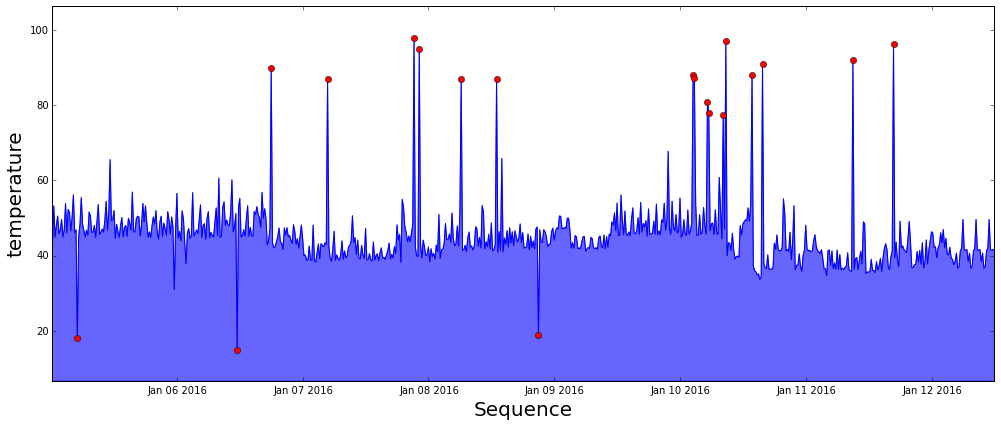

In [13]:
# ignore warnings if any
import warnings
warnings.filterwarnings('ignore')

# render the results as inline charts:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

'''
This function detects the spike and dip by returning a non-zero value 
when the z-score is above 3 (spike) and below -3(dip). Incase if you 
want to capture the smaller spikes and dips, lower the zscore value from 
3 to 2 in this function.
'''
def spike(row):
    if(row['zscore'] >=3 or row['zscore'] <=-3):
        return row[valueHeaderName]
    else:
        return 0
    
pandaDF['spike'] = pandaDF.apply(spike, axis=1)
# select rows that are required for plotting
plotDF = pandaDF[[valueHeaderName,'spike']]
#calculate the y minimum value
y_min = (pandaDF[valueHeaderName].max() - pandaDF[valueHeaderName].min()) / 10
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.set_ylim(plotDF[valueHeaderName].min() - y_min, plotDF[valueHeaderName].max() + y_min)
x_filt = plotDF.index[plotDF.spike != 0]
plotDF['xyvaluexy'] = plotDF[valueHeaderName]
y_filt = plotDF.xyvaluexy[plotDF.spike != 0]
#Plot the raw data in blue colour
line1 = ax.plot(plotDF.index, plotDF[valueHeaderName], '-', color='blue', animated = True, linewidth=1)
#plot the anomalies in red circle
line2 = ax.plot(x_filt, y_filt, 'ro', color='red', linewidth=2, animated = True)
#Fill the raw area
ax.fill_between(plotDF.index, (pandaDF[valueHeaderName].min() - y_min), plotDF[valueHeaderName], interpolate=True, color='blue',alpha=0.6)

# Label the axis
ax.set_xlabel("Sequence",fontsize=20)
ax.set_ylabel(valueHeaderName,fontsize=20)

plt.tight_layout()
plt.legend()
plt.show()

As shown, the red marks are the unexpected spikes and dips whose z-score value is greater than 3 or less than -3. Incase if you want to detect the lower spikes, modify the value to 2 or even lower and run. Similarly, if you want to detect only the higher spikes, try increasing the z-score value from 3 to 4 and beyond.

###7. Derive thresholds
Enter the following command into the next cell to derive the Spike threshold value corresponding to z-score value 3 and click Run.

In [14]:
# calculate the value that is corresponding to z-score 3
(pandaDF[valueHeaderName].std(ddof=0) * 3) + pandaDF[valueHeaderName].mean()

70.601299674769308

Similarly, Enter the following command into the next cell to derive the dip threshold value corresponding to z-score value -3.

In [15]:
# calculate the value that is corresponding to z-score -3
(pandaDF[valueHeaderName].std(ddof=0) * -3) + pandaDF[valueHeaderName].mean()

20.066561436341807

This threshold value can be used to create a rule in the Watson IoT Platform to detect anomalies in the current IoT device events in realtime. This will create an alert in realtime when the current sensor reading crosses the threshold value.

###8. Summary
This Notebook showed how to use the z-score to detect anomalies in the historical timeseries data in simple steps. Also, showed how one can derive the threshold values for the given historical data to create rules accordingly in IBM Watson IoT Platform. Developers can consider this Notebook as a template for detecting anomalies in their historical IoT data and modify the python code depending upon the use case.